<a href="https://colab.research.google.com/github/kuberiitb/retail_price_ai_agent/blob/main/notebooks/RetailPriceAgent_DataCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!pip install langchain_community --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
# !apt-get install sqlite3

In [127]:
import os

In [128]:
from langchain_community.utilities import SQLDatabase

# db = SQLDatabase.from_uri("sqlite:///Chinook.db")
# print(db.dialect)
# print(db.get_usable_table_names())
# db.run("SELECT * FROM Artist LIMIT 10;")

In [6]:
# from dotenv import load_dotenv
# load_dotenv(".env")

In [117]:
# from langchain.chat_models import ChatOpenAI

# if not os.environ["OPENAI_API_KEY"]:
#     os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

In [ ]:
# llm.invoke("Hi").content

'Hello! How can I assist you today?'

# Dataset Creation

In [ ]:
# Inventory data, "product x category x month_year, items_left, "
# sales data, "product x category  month_year,  price, promotion, sales, cost, [profit]"
# competition price "product x category  month_year,  price, promotion"

### Keep only two product for now.

In [10]:
import io
import pandas as pd

core_data = {'men': ['shirt','t-shirt','jacket','Jeans','Trackpants'],
             'women':['Dress','Kurtas','Tops','t-shirt','Jeans','Trackpants'],
             'kids':['shirt','t-shirt','jacket','Jeans','Trackpants','Dress','Kurtas','Tops']
}

data = []
id = 0
for category, products in core_data.items():
  for product in products:
    data.append([id, product, category])
    id+=1

data_product_category = pd.DataFrame(data, columns = ['id','product', 'category'])

data_product_category.head(10)

,id,product,category
0,0,shirt,men
1,1,t-shirt,men
2,2,jacket,men
3,3,Jeans,men
4,4,Trackpants,men
5,5,Dress,women
6,6,Kurtas,women
7,7,Tops,women
8,8,t-shirt,women
9,9,Jeans,women


In [27]:
data_product_category = data_product_category.loc[data_product_category['id'].isin([1,8]),:]
data_product_category

,id,product,category
1,1,t-shirt,men
8,8,t-shirt,women


In [42]:
# Step 1: generate monthly dates
# current data till "2025-08-01"
# forecast data for next 6 months till "2026-02-01"
dates = pd.date_range(start="2023-06-01", end="2026-02-01", freq="MS")

# Step 2: turn into DataFrame
dates_df = pd.DataFrame({"date": dates})

# dates_df
# Step 3: cross join
df_expanded = data_product_category.merge(dates_df, how="cross")

In [43]:
df_expanded.shape

(66, 4)

In [44]:
df_expanded

,id,product,category,date
0,1,t-shirt,men,2023-06-01
1,1,t-shirt,men,2023-07-01
2,1,t-shirt,men,2023-08-01
3,1,t-shirt,men,2023-09-01
4,1,t-shirt,men,2023-10-01
...,...,...,...,...
61,8,t-shirt,women,2025-10-01
62,8,t-shirt,women,2025-11-01
63,8,t-shirt,women,2025-12-01
64,8,t-shirt,women,2026-01-01


# Generating other columns like price, cost etc for the products

In [157]:
import numpy as np
import random
np.random.seed(42)  # reproducibility

metadata = {}
# defaultdict(int)
# Base price, Demand and elasticity differs per product (id)
for id in df_expanded.id.unique():
  metadata[id.item()] = {}
  metadata[id.item()]['base_price'] = random.randint(100, 200)*10
  metadata[id.item()]['base_demand'] = (random.randint(100, 1000)//100) *100
  metadata[id.item()]['elasticity'] = -1 * random.randint(80,120)/100
  metadata[id.item()]['margin'] = -1.0 / metadata[id.item()]['elasticity']

def generate_sales(row):
    # Price with random fluctuation
    base_price = metadata[row["id"]]['base_price']
    margin = metadata[row["id"]]['margin']

    cost = round(base_price / (1 + margin))
    price = base_price + np.random.randint(-10, 10)

    # Random promotion (20% chance)
    promotion = np.random.choice([0, 10, 20, 30], p=[0.5, 0.2, 0.2, 0.1])

    price = round(price * (1-promotion/100))
    # Seasonality factor (e.g., high in Dec, low in Jan/Feb)
    month = row["date"].month
    if month in [11, 12]:      # festive
        seasonality = 1.3
    elif month in [6, 7, 8]:   # summer boost
        seasonality = 1.1
    else:
        seasonality = 0.9

    # Sales formula
    sales = round(100 * (500 / price) * seasonality * (1.2 if promotion > 0 else 1.0))
    # sales = sales *  + np.random.normal(0, 10)  # add noise
    sales_value = price * sales
    profit = (price - cost) * sales

    return pd.Series([price, cost,  promotion, seasonality, sales, round(sales_value), round(profit)])

# Apply generator
df_expanded[["price", "cost","promotion", "seasonality", "sales", "sales_value", "profit"]] = df_expanded.apply(generate_sales, axis=1)

print(df_expanded.head(10))

   id  product category       date   price   cost  promotion  seasonality  \
0   1  t-shirt      men 2023-06-01  1157.0  703.0       20.0          1.1   
1   1  t-shirt      men 2023-07-01  1163.0  703.0       20.0          1.1   
2   1  t-shirt      men 2023-08-01  1446.0  703.0        0.0          1.1   
3   1  t-shirt      men 2023-09-01  1450.0  703.0        0.0          0.9   
4   1  t-shirt      men 2023-10-01  1443.0  703.0        0.0          0.9   
5   1  t-shirt      men 2023-11-01  1442.0  703.0        0.0          1.3   
6   1  t-shirt      men 2023-12-01  1153.0  703.0       20.0          1.3   
7   1  t-shirt      men 2024-01-01  1445.0  703.0        0.0          0.9   
8   1  t-shirt      men 2024-02-01  1440.0  703.0        0.0          0.9   
9   1  t-shirt      men 2024-03-01  1451.0  703.0        0.0          0.9   

   sales  sales_value   profit  
0   57.0      65949.0  25878.0  
1   57.0      66291.0  26220.0  
2   38.0      54948.0  28234.0  
3   31.0      44950.

In [158]:
df_expanded.profit.min()

18001.0

# Creating historical and forecast data

In [159]:
historical_data = df_expanded.loc[df_expanded['date']<='2025-08-01',:]
forecast_data = df_expanded.loc[df_expanded['date']>'2025-08-01',:]

In [160]:
historical_data.head()

,id,product,category,date,price,cost,promotion,seasonality,sales,sales_value,profit
0,1,t-shirt,men,2023-06-01,1157.0,703.0,20.0,1.1,57.0,65949.0,25878.0
1,1,t-shirt,men,2023-07-01,1163.0,703.0,20.0,1.1,57.0,66291.0,26220.0
2,1,t-shirt,men,2023-08-01,1446.0,703.0,0.0,1.1,38.0,54948.0,28234.0
3,1,t-shirt,men,2023-09-01,1450.0,703.0,0.0,0.9,31.0,44950.0,23157.0
4,1,t-shirt,men,2023-10-01,1443.0,703.0,0.0,0.9,31.0,44733.0,22940.0


# Update sale on forecast_data

In [161]:
forecast_data = forecast_data.loc[:,['id', 'product', 'category', 'date']]

historical_average = historical_data.groupby(['id', 'product', 'category'])['sales'].mean().round().reset_index()
print("historical_average")
print(historical_average)

forecast_data = forecast_data.merge(historical_average, on=['id', 'product', 'category'], how='left')
print("forecast_data")
print(forecast_data)

historical_average
   id  product category  sales
0   1  t-shirt      men   42.0
1   8  t-shirt    women   37.0
forecast_data
    id  product category       date  sales
0    1  t-shirt      men 2025-09-01   42.0
1    1  t-shirt      men 2025-10-01   42.0
2    1  t-shirt      men 2025-11-01   42.0
3    1  t-shirt      men 2025-12-01   42.0
4    1  t-shirt      men 2026-01-01   42.0
5    1  t-shirt      men 2026-02-01   42.0
6    8  t-shirt    women 2025-09-01   37.0
7    8  t-shirt    women 2025-10-01   37.0
8    8  t-shirt    women 2025-11-01   37.0
9    8  t-shirt    women 2025-12-01   37.0
10   8  t-shirt    women 2026-01-01   37.0
11   8  t-shirt    women 2026-02-01   37.0


# Create current inventory

In [219]:
# 2 to 4 months of sales
inventory_data = historical_average.rename(columns={'sales':'stock'})
print("inventory_data")
print(inventory_data)

inventory_data['stock'] = inventory_data.apply(lambda x:x['stock']*random.randint(2,4),axis=1)
inventory_data

inventory_data
   id  product category  stock
0   1  t-shirt      men   42.0
1   8  t-shirt    women   37.0


,id,product,category,stock
0,1,t-shirt,men,168.0
1,8,t-shirt,women,74.0


# Create competitior current price

In [205]:
our_price = historical_data.groupby(['id', 'product', 'category'])['price'].mean().round().reset_index()
print("Our Price")
print(our_price)

competitior_price = our_price
competitior_price['price'] = competitior_price['price'].map(lambda x:round(x*np.random.choice([0.8,0.9,1.1,1.2])))

competitior_price['promotion'] = competitior_price.apply(lambda x: np.random.choice(['0','0.1','0.2','BOGO','BTGO'], p=[0.2,0.1,0.1,0.3,0.3]),axis=1)

print("competitior_price")
print(competitior_price)
# adjust price by promotion value
promotion_to_price_mapping = {'0':1,'0.1':0.9,'0.2':0.8,'BOGO':0.5,'BTGO':0.7}
competitior_price['price_change'] = competitior_price['promotion'].map(promotion_to_price_mapping)
competitior_price['price'] = competitior_price.apply(lambda x: x['price']* x['price_change'], axis=1)

print("competitior_price")
print(competitior_price)

Our Price
   id  product category   price
0   1  t-shirt      men  1362.0
1   8  t-shirt    women  1513.0
competitior_price
   id  product category  price promotion
0   1  t-shirt      men   1634      BOGO
1   8  t-shirt    women   1210       0.2
competitior_price
   id  product category  price promotion  price_change
0   1  t-shirt      men  817.0      BOGO           0.5
1   8  t-shirt    women  968.0       0.2           0.8


In [164]:
competitior_price

,id,product,category,price
0,1,t-shirt,men,1226
1,8,t-shirt,women,1210


In [206]:
metadata

{1: {'base_price': 1450,
  'base_demand': 800,
  'elasticity': -0.94,
  'margin': 1.0638297872340425},
 8: {'base_price': 1630,
  'base_demand': 800,
  'elasticity': -0.86,
  'margin': 1.1627906976744187}}

# Save the datsets to SQLite so that later Text2SQL agent can use it

In [220]:
import sqlite3
import pandas as pd

# Example list of dataframes with names
dataframes = {
    "historical_data": historical_data,
    "forecast_data": forecast_data,
    "inventory_data": inventory_data,
    "competitior_price": competitior_price
}

# Create connection to SQLite database (creates file if not exists)
conn = sqlite3.connect("my_database.db")

# Loop through and save each dataframe as a table
for table_name, df in dataframes.items():
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print(f"Saved {table_name} to SQLite")

# Close connection
conn.close()

Saved historical_data to SQLite
Saved forecast_data to SQLite
Saved inventory_data to SQLite
Saved competitior_price to SQLite


In [222]:
# Checking the data in SQLite
import sqlite3
import pandas as pd

db = sqlite3.connect("my_database.db")

df_historical = pd.read_sql("SELECT * FROM historical_data", db)
df_forecast = pd.read_sql("SELECT * FROM forecast_data", db)
df_inventory = pd.read_sql("SELECT * FROM inventory_data", db)
df_competitior = pd.read_sql("SELECT * FROM competitior_price", db)
print(historical_data.head())
print(df_forecast.head())
print(df_inventory)
print(df_competitior.head())

db.close()

   id  product category       date   price   cost  promotion  seasonality  \
0   1  t-shirt      men 2023-06-01  1157.0  703.0       20.0          1.1   
1   1  t-shirt      men 2023-07-01  1163.0  703.0       20.0          1.1   
2   1  t-shirt      men 2023-08-01  1446.0  703.0        0.0          1.1   
3   1  t-shirt      men 2023-09-01  1450.0  703.0        0.0          0.9   
4   1  t-shirt      men 2023-10-01  1443.0  703.0        0.0          0.9   

   sales  sales_value   profit  
0   57.0      65949.0  25878.0  
1   57.0      66291.0  26220.0  
2   38.0      54948.0  28234.0  
3   31.0      44950.0  23157.0  
4   31.0      44733.0  22940.0  
   id  product category                 date  sales
0   1  t-shirt      men  2025-09-01 00:00:00   42.0
1   1  t-shirt      men  2025-10-01 00:00:00   42.0
2   1  t-shirt      men  2025-11-01 00:00:00   42.0
3   1  t-shirt      men  2025-12-01 00:00:00   42.0
4   1  t-shirt      men  2026-01-01 00:00:00   42.0
   id  product category  st

### Langchain agent will use SQLAlchemy format similar like this

In [223]:
from sqlalchemy import create_engine

db = SQLDatabase.from_uri("sqlite:///my_database.db")
print(db.get_usable_table_names())

['competitior_price', 'forecast_data', 'historical_data', 'inventory_data']


In [224]:
db.run("SELECT * FROM historical_data LIMIT 10;")

"[(1, 't-shirt', 'men', '2023-06-01 00:00:00', 1157.0, 703.0, 20.0, 1.1, 57.0, 65949.0, 25878.0), (1, 't-shirt', 'men', '2023-07-01 00:00:00', 1163.0, 703.0, 20.0, 1.1, 57.0, 66291.0, 26220.0), (1, 't-shirt', 'men', '2023-08-01 00:00:00', 1446.0, 703.0, 0.0, 1.1, 38.0, 54948.0, 28234.0), (1, 't-shirt', 'men', '2023-09-01 00:00:00', 1450.0, 703.0, 0.0, 0.9, 31.0, 44950.0, 23157.0), (1, 't-shirt', 'men', '2023-10-01 00:00:00', 1443.0, 703.0, 0.0, 0.9, 31.0, 44733.0, 22940.0), (1, 't-shirt', 'men', '2023-11-01 00:00:00', 1442.0, 703.0, 0.0, 1.3, 45.0, 64890.0, 33255.0), (1, 't-shirt', 'men', '2023-12-01 00:00:00', 1153.0, 703.0, 20.0, 1.3, 68.0, 78404.0, 30600.0), (1, 't-shirt', 'men', '2024-01-01 00:00:00', 1445.0, 703.0, 0.0, 0.9, 31.0, 44795.0, 23002.0), (1, 't-shirt', 'men', '2024-02-01 00:00:00', 1440.0, 703.0, 0.0, 0.9, 31.0, 44640.0, 22847.0), (1, 't-shirt', 'men', '2024-03-01 00:00:00', 1451.0, 703.0, 0.0, 0.9, 31.0, 44981.0, 23188.0)]"

In [225]:
db.run("SELECT * FROM competitior_price LIMIT 10;")

"[(1, 't-shirt', 'men', 817.0, 'BOGO', 0.5), (8, 't-shirt', 'women', 968.0, '0.2', 0.8)]"

In [226]:
db.run("SELECT * FROM forecast_data LIMIT 10;")

"[(1, 't-shirt', 'men', '2025-09-01 00:00:00', 42.0), (1, 't-shirt', 'men', '2025-10-01 00:00:00', 42.0), (1, 't-shirt', 'men', '2025-11-01 00:00:00', 42.0), (1, 't-shirt', 'men', '2025-12-01 00:00:00', 42.0), (1, 't-shirt', 'men', '2026-01-01 00:00:00', 42.0), (1, 't-shirt', 'men', '2026-02-01 00:00:00', 42.0), (8, 't-shirt', 'women', '2025-09-01 00:00:00', 37.0), (8, 't-shirt', 'women', '2025-10-01 00:00:00', 37.0), (8, 't-shirt', 'women', '2025-11-01 00:00:00', 37.0), (8, 't-shirt', 'women', '2025-12-01 00:00:00', 37.0)]"

In [227]:
db.run("SELECT * FROM inventory_data LIMIT 10;")

"[(1, 't-shirt', 'men', 168.0), (8, 't-shirt', 'women', 74.0)]"

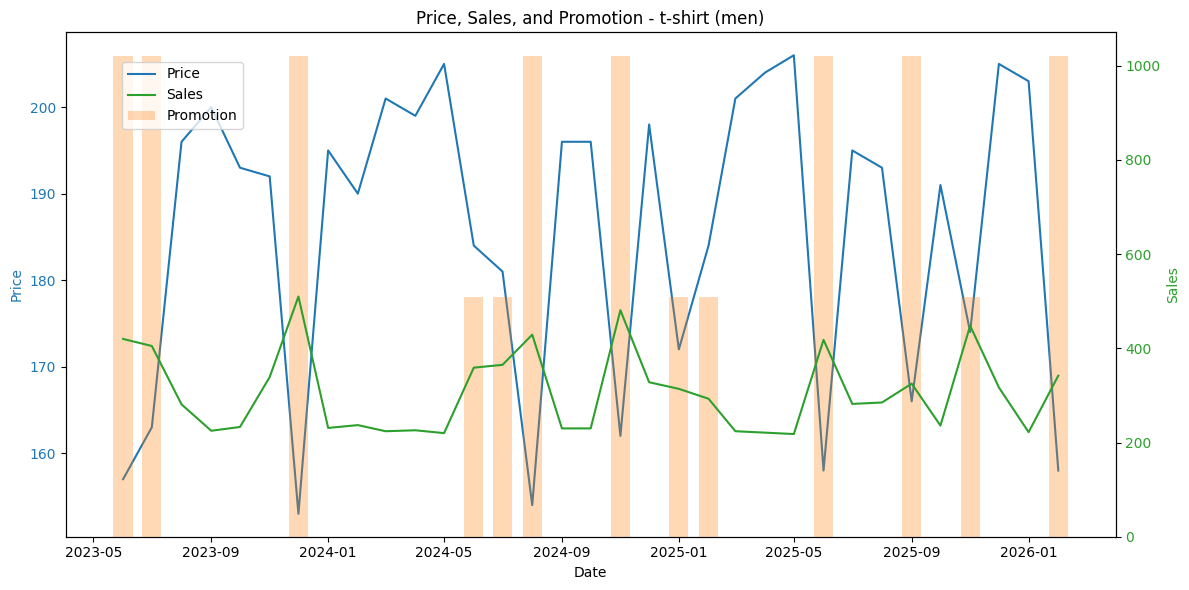

In [153]:
import matplotlib.pyplot as plt
product='t-shirt'
category='men'
# Filter data

data = df_expanded.loc[(df_expanded['category']==category) & (df_expanded['product']==product)].copy()

# Sort by date (important for line plot)
data = data.sort_values("date")

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Price line
ax1.set_xlabel("Date")
ax1.set_ylabel("Price", color="tab:blue")
ax1.plot(data["date"], data["price"], color="tab:blue", label="Price")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Sales line (second axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Sales", color="tab:green")
ax2.plot(data["date"], data["sales"], color="tab:green", label="Sales")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Promotion bars
ax2.bar(
    data["date"],
    data["promotion"] * data["sales"].max() * 0.1,  # scale bar height
    width=20,
    alpha=0.3,
    color="tab:orange",
    label="Promotion"
)

# Legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.title(f"Price, Sales, and Promotion - {product} ({category})")
plt.tight_layout()
plt.show()


# Function to show impact of price change given elasticity

In [154]:
def simulate_demand(elasticity, discount = 0.1, P1=100, Q1=1000):
    """
    Simulate new demand and revenue given price change and elasticity.

    Parameters:
        elasticity (float): Price elasticity of demand (negative)
        discount (float): Discount (in range 0-1)
        P1 (float): Initial price
        Q1 (float): Initial quantity

    Returns:
        dict with new quantity, new revenue, % change in Q, % change in revenue
    """
    P2 = P1 * (1+discount)
    # % change in quantity
    pct_change_Q = elasticity * discount

    # new quantity
    Q2 = Q1 * (1 + pct_change_Q)

    # revenues
    R1 = P1 * Q1
    R2 = P2 * Q2

    return {
        "Initial Price": P1,
        "New Price": P2,
        "Initial Quantity": Q1,
        "New Quantity": round(Q2, 2),
        "Initial Revenue": round(R1, 2),
        "New Revenue": round(R2, 2),
        "% Change Quantity": round(pct_change_Q * 100, 2),
        "% Change Revenue": round(((R2 - R1) / R1) * 100, 2)
    }

# Example runs:
print(simulate_demand(-0.6, -0.1))
print(simulate_demand(-1.5, -0.1))

print(simulate_demand(-0.6, 0.1))
print(simulate_demand(-1.5, 0.1))


{'Initial Price': 100, 'New Price': 90.0, 'Initial Quantity': 1000, 'New Quantity': 1060.0, 'Initial Revenue': 100000, 'New Revenue': 95400.0, '% Change Quantity': 6.0, '% Change Revenue': -4.6}
{'Initial Price': 100, 'New Price': 90.0, 'Initial Quantity': 1000, 'New Quantity': 1150.0, 'Initial Revenue': 100000, 'New Revenue': 103500.0, '% Change Quantity': 15.0, '% Change Revenue': 3.5}
{'Initial Price': 100, 'New Price': 110.00000000000001, 'Initial Quantity': 1000, 'New Quantity': 940.0, 'Initial Revenue': 100000, 'New Revenue': 103400.0, '% Change Quantity': -6.0, '% Change Revenue': 3.4}
{'Initial Price': 100, 'New Price': 110.00000000000001, 'Initial Quantity': 1000, 'New Quantity': 850.0, 'Initial Revenue': 100000, 'New Revenue': 93500.0, '% Change Quantity': -15.0, '% Change Revenue': -6.5}


In [155]:
print(simulate_demand(-0.9, -0.5))
print(simulate_demand(-1.1, -0.5))

{'Initial Price': 100, 'New Price': 50.0, 'Initial Quantity': 1000, 'New Quantity': 1450.0, 'Initial Revenue': 100000, 'New Revenue': 72500.0, '% Change Quantity': 45.0, '% Change Revenue': -27.5}
{'Initial Price': 100, 'New Price': 50.0, 'Initial Quantity': 1000, 'New Quantity': 1550.0, 'Initial Revenue': 100000, 'New Revenue': 77500.0, '% Change Quantity': 55.0, '% Change Revenue': -22.5}
